In [1]:
pip install tensorflow==2.15.0

In [2]:
!pip install tensorflow_decision_forests==1.8.1

In [3]:
!pip install tensorflowjs


In [4]:
!tensorflowjs_converter --version


2024-11-24 16:50:52.752695: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 16:50:52.752762: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 16:50:52.754108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 16:50:52.763508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 16:50:54.405875: W tensorflow/compiler/tf2

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import numpy as np
import tensorflowjs as tfjs
import unittest
from collections import Counter
import seaborn as sns

In [6]:
file_path = 'cleaned_framingham.csv'
data = pd.read_csv(file_path)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   currentSmoker    4240 non-null   int64  
 3   cigsPerDay       4240 non-null   float64
 4   BPMeds           4240 non-null   float64
 5   prevalentStroke  4240 non-null   int64  
 6   prevalentHyp     4240 non-null   int64  
 7   diabetes         4240 non-null   int64  
 8   totChol          4240 non-null   float64
 9   sysBP            4240 non-null   float64
 10  diaBP            4240 non-null   float64
 11  BMI              4240 non-null   float64
 12  heartRate        4240 non-null   float64
 13  glucose          4240 non-null   float64
 14  TenYearCHD       4240 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 497.0 KB


In [8]:
data.head(10)

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,0,63,0,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,0,45,1,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,1,52,0,0.0,0.0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,1,43,1,30.0,0.0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


In [9]:
data.describe()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000
mean,0.429245,49.580189,0.494104,8.944340,0.029245,0.005896,0.310613,0.025708,236.667689,132.354599,82.897759,25.799005,75.878774,81.600943,0.151887
std,0.495027,8.572942,0.500024,11.904777,0.168513,0.076569,0.462799,0.158280,44.328480,22.033300,11.910394,4.070775,12.023937,22.860340,0.358953
min,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.077500,68.000000,72.000000,0.000000
50%,0.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,262.000000,144.000000,90.000000,28.032500,83.000000,85.000000,0.000000
max,1.000000,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [10]:
missing_values = data.isnull().sum()
missing_values

,0
male,0
age,0
currentSmoker,0
cigsPerDay,0
BPMeds,0
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,0
sysBP,0


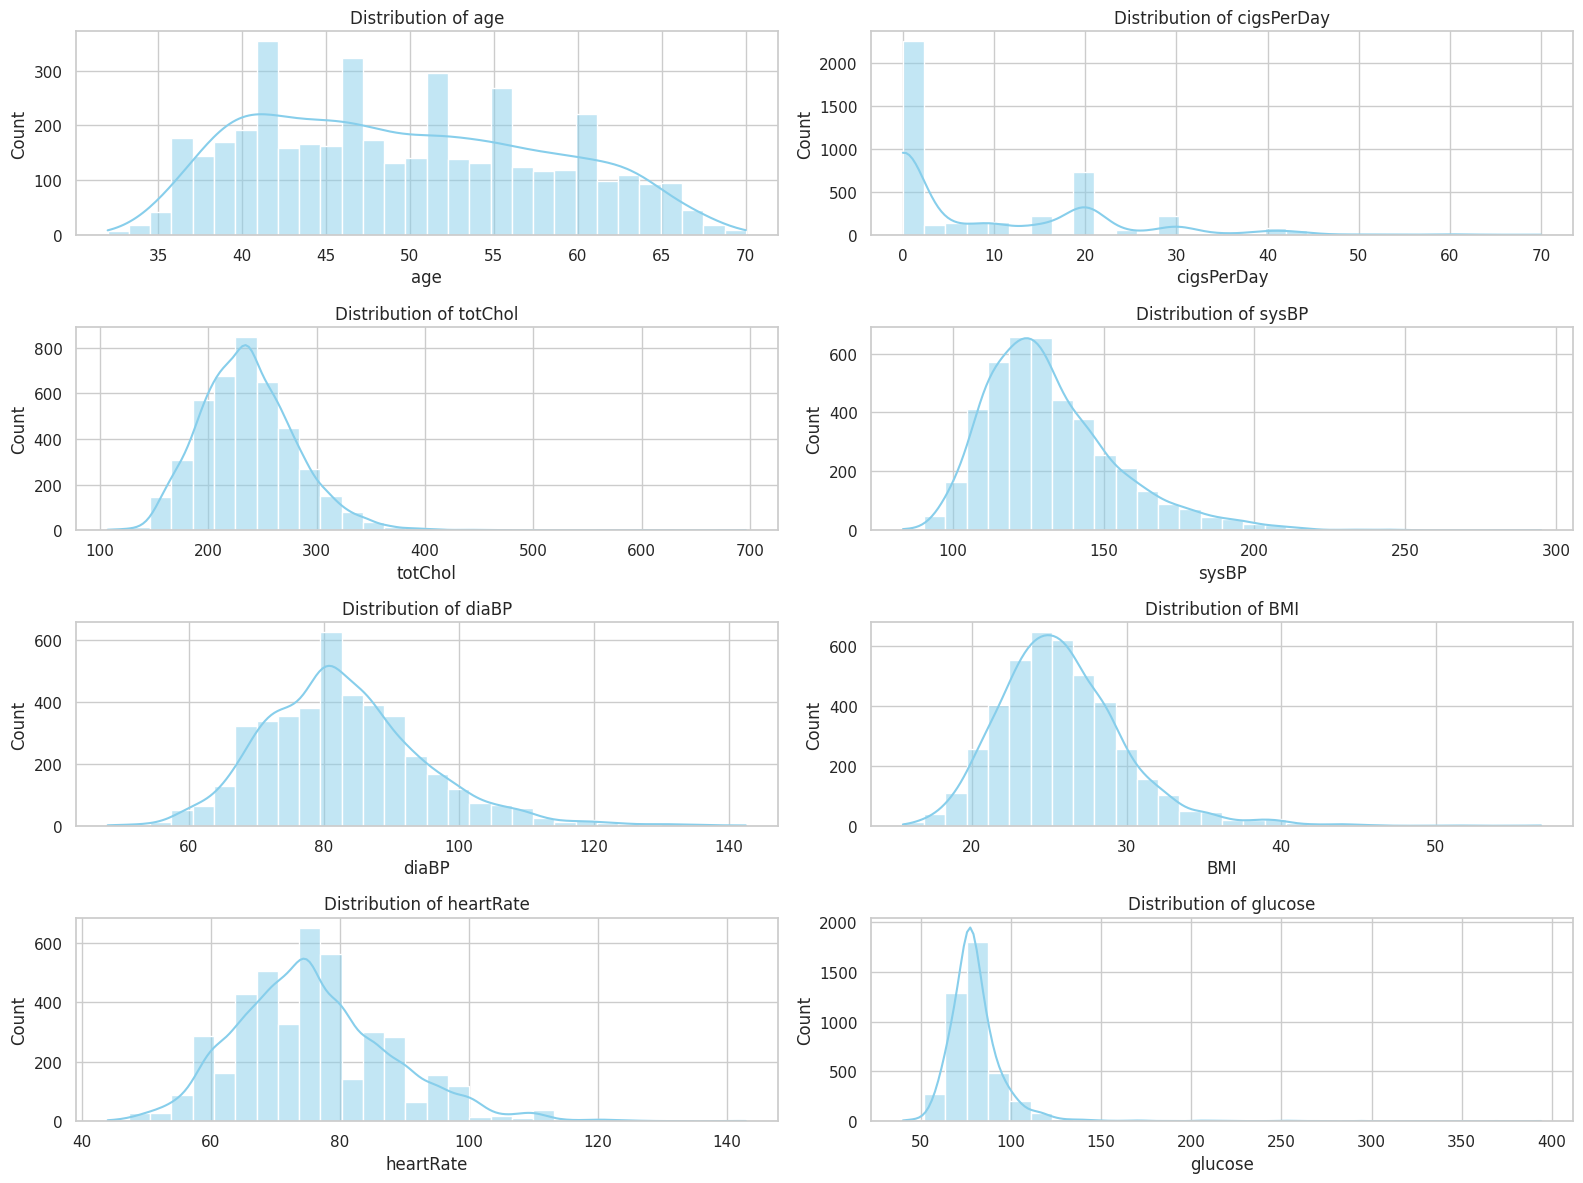

In [11]:
sns.set(style="whitegrid")

plt.figure(figsize=(16, 12))
for i, column in enumerate(['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'], 1):
    plt.subplot(4, 2, i)
    sns.histplot(data[column], kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()


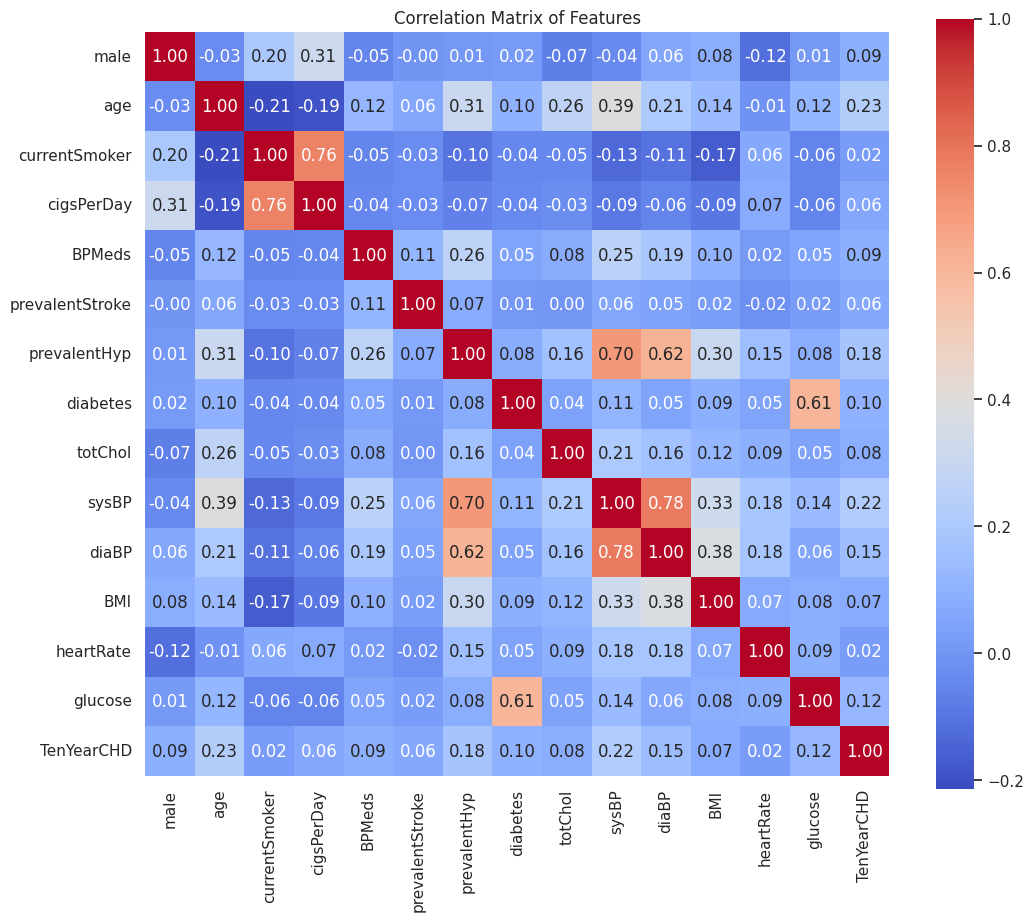

In [12]:
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Features")
plt.show()

<ipython-input-13-2826c997faf6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TenYearCHD', data=data, palette="viridis")


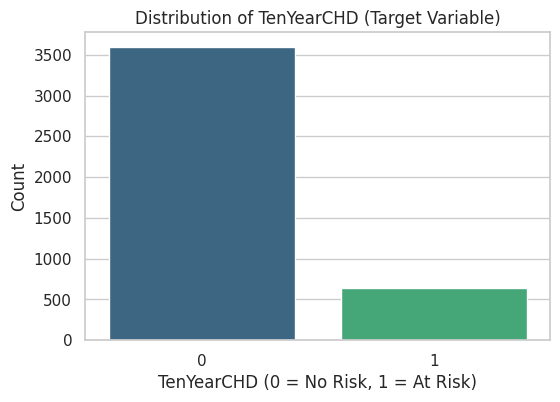

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(x='TenYearCHD', data=data, palette="viridis")
plt.title("Distribution of TenYearCHD (Target Variable)")
plt.xlabel("TenYearCHD (0 = No Risk, 1 = At Risk)")
plt.ylabel("Count")
plt.show()

In [14]:
X = data[['male', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke',
          'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']]
y = data['TenYearCHD']

In [15]:
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)
print("Class distribution after SMOTE:", Counter(y_balanced))

Class distribution after SMOTE: Counter({0: 3596, 1: 3596})


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
scaler_params = {"mean": scaler.mean_.tolist(), "scale": scaler.scale_.tolist()}
print("Scaler parameters:", scaler_params)

Scaler parameters: {'mean': [0.381192421345385, 51.22979315139927, 0.45715278984877455, 9.508527313545642, 0.04399110235597926, 0.0038240917782026767, 0.33078393881453155, 0.02902833304362941, 239.94101542928044, 136.50776972786105, 84.62183880739985, 26.06826981038074, 76.1527961326235, 83.95559865051148], 'scale': [0.48567968791604565, 8.183900258471727, 0.49816073368166686, 11.916458034152472, 0.18405919709446378, 0.06172088868668824, 0.4704954034173722, 0.16788594022233533, 44.91651448259721, 23.449529551614948, 12.370881356316398, 3.964476014167865, 11.566225865315907, 30.495184502275865]}


In [19]:
class TestScaling(unittest.TestCase):
    def test_scaler_params(self):
        self.assertIsNotNone(scaler.mean_, "meannya mana wak")
        self.assertIsNotNone(scaler.scale_, "scale nya ngilng")

unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestScaling))


.
----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [20]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weights)

Class weights: {0: 1.0089442300947036, 1: 0.9912129565816679}


In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [23]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
144/144 [==============================] - 1s 4ms/step - loss: 0.6658 - accuracy: 0.5980 - val_loss: 0.6106 - val_accuracy: 0.6742
Epoch 2/100
144/144 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.6441 - val_loss: 0.5949 - val_accuracy: 0.6933
Epoch 3/100
144/144 [==============================] - 0s 3ms/step - loss: 0.6132 - accuracy: 0.6717 - val_loss: 0.5848 - val_accuracy: 0.7003
Epoch 4/100
144/144 [==============================] - 0s 3ms/step - loss: 0.6027 - accuracy: 0.6743 - val_loss: 0.5783 - val_accuracy: 0.7011
Epoch 5/100
144/144 [==============================] - 0s 3ms/step - loss: 0.5980 - accuracy: 0.6817 - val_loss: 0.5709 - val_accuracy: 0.7063
Epoch 6/100
144/144 [==============================] - 0s 3ms/step - loss: 0.5924 - accuracy: 0.6877 - val_loss: 0.5662 - val_accuracy: 0.7046
Epoch 7/100
144/144 [==============================] - 0s 2ms/step - loss: 0.5855 - accuracy: 0.6977 - val_loss: 0.5648 - val_accuracy: 0.7133

In [24]:
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

45/45 [==============================] - 0s 1ms/step - loss: 0.4884 - accuracy: 0.7575
Test Loss: 0.4884
Test Accuracy: 0.7575


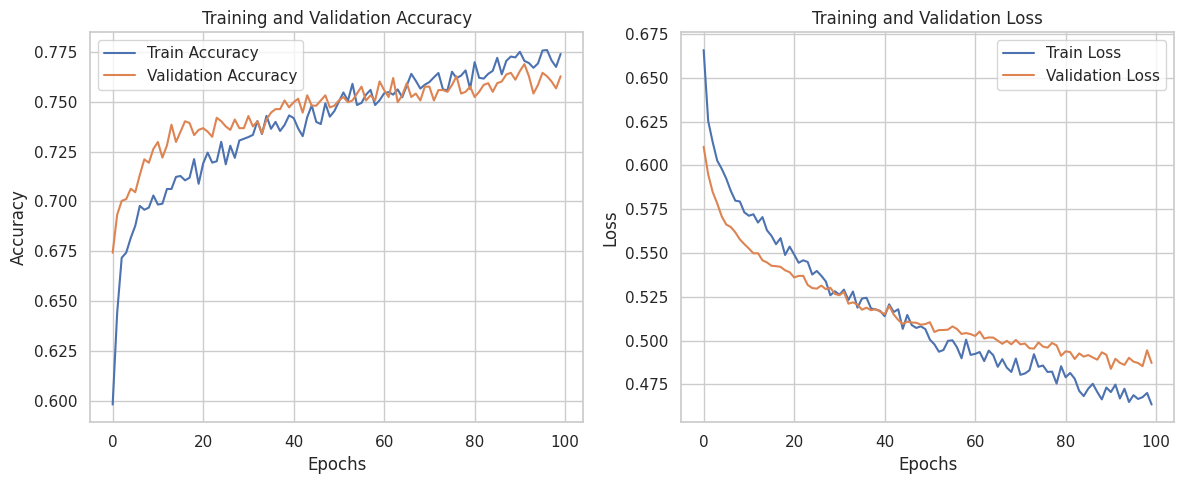

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [26]:
model.save("tfjs_model.keras")
tfjs.converters.save_keras_model(tf.keras.models.load_model("tfjs_model.keras"), "tfjs")

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
class TestModelInference(unittest.TestCase):
    def test_inference(self):
        sample_input = np.expand_dims(X_test_scaled[0], axis=0)
        prediction = model.predict(sample_input)
        self.assertGreaterEqual(prediction[0][0], 0.0, "Prediction nguwawor")
        self.assertLessEqual(prediction[0][0], 1.0, "Prediction nguwawor part 2")

unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestModelInference))

1/1 [==============================] - 0s 64ms/step


.
----------------------------------------------------------------------
Ran 1 test in 0.105s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [28]:
class TestModelConversion(unittest.TestCase):
    def test_tfjs_conversion(self):
        import os
        self.assertTrue(os.path.isdir("tfjs"), "gaada kocak")
        self.assertTrue(any(fname.endswith('.json') for fname in os.listdir("tfjs")), "maybe the json file is the friends we made along the way")
        self.assertTrue(any(fname.endswith('.bin') for fname in os.listdir("tfjs")), "weightnya gaada kocak")

unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestModelConversion))

.
----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>